In [1]:
print('hello')

hello


In [1]:
#@title Install libraries for macOS to run tensorflow using available GPU (optional)
%pip install tensorflow-metal tensorflow-macos

Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Installations
%pip install pandas numpy matplotlib seaborn medmnist scikit-learn Pillow tensorflow opencv-python scikit-image tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
#@title Set GPU memory growth (for macOS)
import tensorflow as tf
def setgpu():
  gpus = tf.config.list_physical_devices('GPU')
  print(gpus)
  for gpu in gpus:
      # tf.config.experimental.set_memory_growth(gpu, True)
      tf.config.set_visible_devices(gpus[0], 'GPU')
      print('gpus',gpu)

In [4]:
#@title Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from medmnist import RetinaMNIST
import PIL as pill
import pandas as pd
from collections import Counter
from abc import ABC, abstractmethod
from typing import Sequence
import seaborn as sns;
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import os
import datetime
from tensorflow.keras.metrics import AUC
from tensorflow import keras

In [5]:
#@title Dataset Download
train = RetinaMNIST(split='train',download=True,size=64)
test = RetinaMNIST(split='test',download=True,size=64)
val = RetinaMNIST(split='val',download=True,size=64)

*********        Dataset Description        *********
Dataset RetinaMNIST of size 64 (retinamnist_64)
    Number of datapoints: 1080
    Root location: /Users/saiharshagangari/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
*********        Plotting sample images        *********


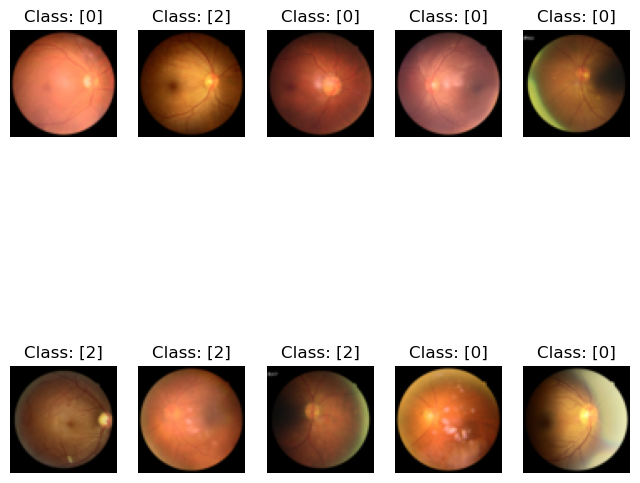

In [6]:
#@title Elementary Data Analysis
#Determine each category format: {class label, train sample count}
#RetinaMNIST = " {0:486, 1:128, 2:206, 3: 194, 4: 66}"
train_dataset = list(train)

def describe_dataset(train_data):
    print(train)

def plot_images(train_subset):
    try:
        figure, axes = plt.subplots(2,5, figsize=(8,8))
        axes = axes.flatten()
        for id in range(0,10):
            img,lbl = train_subset[id]
            axes[id].imshow(img)
            axes[id].set_title(f'Class: {lbl}')
            axes[id].axis('off')
        plt.show()


    except Exception as e:
        print('Error' ,e)

print('*********        Dataset Description        *********')
describe_dataset(train)

print('*********        Plotting sample images        *********')
sample_subset = list(train)[570:580]
plot_images(sample_subset)


*****          Visualize class 4 samples       ********


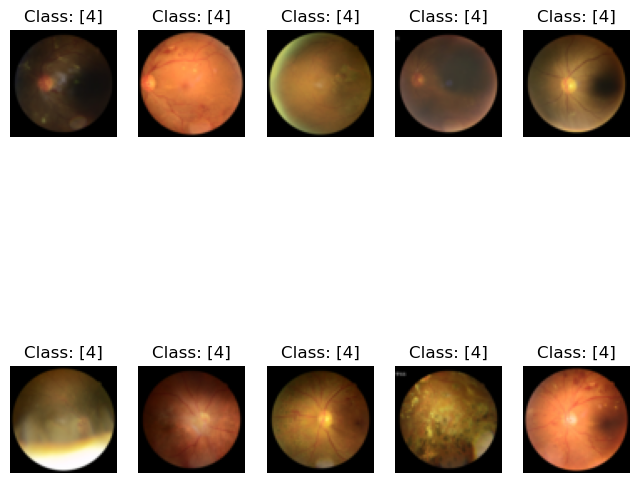

 ********         Shape of image         ********
shape of image: (64, 64) and label size:  1


66

In [7]:
#@title  <h3>EDA Part 2 - Visualizing Class 4 samples</h3>
class4_dataset = [x for x in train_dataset if x[1] == 4]

print("*****          Visualize class 4 samples       ********")
plot_images(class4_dataset[1:11])

print(" ********         Shape of image         ********")
image = class4_dataset[0][0]
label = class4_dataset[0][1]
print(f"shape of image: {image.size} and label size:  {label.size}")
train[0]


len(class4_dataset)

In [8]:
#@title Print class count per dataset
def getClassCount(data:list):
  classes={}
  for sample in data:
    label = sample[1][0]
    if label in classes:
      classes[label] += 1
    else:
      classes[label] = 1
  return classes


print(getClassCount(train_dataset))


{0: 486, 4: 66, 3: 194, 2: 206, 1: 128}


We can see that there is clear imbalance in the classes. We now upsample using traditional data augmentation technique i.e flip, rotate 90deg/ 180deg/270deg

In [9]:
#@title Base Algorithm
class BaseLearningAlogrithm(ABC):
    @abstractmethod
    def fit(self,xtrain:np.array,ytrain:np.array,xval:np.array,yval:np.array) -> tf.keras.callbacks.History:
        """Implement custom logic to train the GAN using train and validation data"""

    @abstractmethod
    def predict(self,xtest:list,ytest:list)->list:
        """Implement custom logic to test the GAN using test data"""

    @property
    @abstractmethod
    def name(self)->str:
        """Returns algorithm name"""

    @property
    def layers(self)-> Sequence[tf.keras.layers.Layer]:
        raise NotImplementedError()

    @property
    def input(self):
        raise NotImplementedError()


In [79]:
#@title Utility methods
def normalize_image(data):
    return data.astype('float32')/255.0

def prepare_x_y_columns(data:list):
    X = [np.array(sample[0]) for sample in data]
    Y = [np.array(sample[1]) for sample in data]
    X = normalize_image(np.array(X,dtype='float32'))
    Y = np.squeeze(to_categorical(np.array(Y,dtype='int'),num_classes=5))
    return (X,Y)

# def prepare_x_y_columns(data: list):
#     X = [np.array(sample[0]) for sample in data]     # images
#     Y = [np.array(sample[1]) for sample in data]     # labels
#     X_resized = [tf.image.resize(img, (128, 128)).numpy() for img in X]
#     X_resized = np.array(X_resized, dtype='float32')
#     X_resized /= 255.0
#     Y = np.squeeze(to_categorical(np.array(Y, dtype='int'), num_classes=5))
#     return X_resized, Y

In [11]:
#@title Training and Evaluation methods
def train_eval(learning_algo: BaseLearningAlogrithm, ds_train, ds_val, ds_test):
  """Trains and evaluates the generic model."""

  history = learning_algo.fit(ds_train[0],ds_train[1], ds_val[0],ds_val[1])

  y_test = ds_test[1]
  images = ds_test[0]
  print('val input shape :',images.shape)
  y_pred =  learning_algo.predict(images)

  print("*******   Confusion Matrix *********")
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(5,5)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(5)],
              yticklabels=['%d' %i for i in range(5)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)
  plt.show()

  print("*******   Classification Report: *********")
  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(5)]))

  return history



RESNET model to extract features

In [86]:
#@title Architecting CNN to establish baseline score using RESNET
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras import metrics

class CNN(BaseLearningAlogrithm):
    def __init__(self):
        self.model = None
        self.epochs = 35
        self.loss = tf.losses.CategoricalCrossentropy()
        self.model = self.getmodel()
        self.learning_rate = 3e-4
        # self.learning_rate_val_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_lr=5e-7)
        # self.learning_rate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(self.learning_rate,decay_steps=70, end_learning_rate=2e-7,cycle=False)
        # self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_rate=0.978, decay_steps=1000,staircase=False)
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate,clipnorm=1.0)
        self.history = None

    @property
    def layers(self):
        return self.model.layers

    def name(self)->str:
        return 'CNN hybrid model'

    # def scheduler(self,epoch,currLearningRate):
    #     print('current epoch', epoch, 'current learning rate: ',currLearningRate)
    #     if epoch <= 15:
    #         return currLearningRate
    #     elif 16<= epoch <=20:
    #         return currLearningRate-currLearningRate*0.02
    #     elif 21<= epoch <= 35:
    #         return currLearningRate - currLearningRate*0.3
    #     elif 36<= epoch <=40:
    #         return currLearningRate - currLearningRate*0.45
    #     elif epoch>40:
    #         return currLearningRate * ((1-(epoch/self.epochs))**2)


    def getmodel(self) -> tf.keras.models.Sequential:
        resnet_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64,3))
        for layer in resnet_model.layers:
            layer.trainable = False
        for layer in resnet_model.layers[-15:]:
            layer.trainable = True
        #***********     Start of Feed forward Neural Network       **********
        hybrid_model = tf.keras.Sequential([
            resnet_model,
            tf.keras.layers.GlobalMaxPooling2D(),
            # tf.keras.layers.Dense(225,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
            # tf.keras.layers.Dropout(0.2),
            # tf.keras.layers.Dense(175,activation='relu'),
            # tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(110,activation='relu'),
            tf.keras.layers.Dense(90,activation='relu'),
            tf.keras.layers.Dense(22,activation='relu'),
            tf.keras.layers.Dropout(0.1),

            #***********      Output layer       **********
            tf.keras.layers.Dense(5,activation='softmax')
        ])
        return hybrid_model

    def fit(self,xtrain,ytrain,xval,yval)->Sequence[tf.keras.callbacks.History]:
        print('Running fit method of CNN')
        # lRateSchedulerCallback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,restore_best_weights=True)
        self.model.compile(optimizer=self.optimizer,loss=self.loss,metrics=[metrics.Precision(name='precision'),
                                                                            metrics.Recall(name='recall'),
                                                                            metrics.F1Score(name='f1_score'),
                                                                            metrics.AUC(name='auc',curve='ROC')
                                                                          ])
        self.history = self.model.fit(xtrain,ytrain, epochs=self.epochs,validation_data=(xval,yval),callbacks=[earlyStoppingCallback])
        return self.history

    #Predict method
    def predict(self,xtest):
        return np.argmax(self.model.predict(xtest),axis=1)

In [ ]:
#@title Create a CNN to establish benchmark - Don't run this code
# from tensorflow.keras import metrics
# class CNN(BaseLearningAlogrithm):
#     def __init__(self):
#         self.epochs = 45
#         self.loss = tf.losses.CategoricalCrossentropy()
#         self.model = self.getmodel()
#         self.learning_rate = 3e-4

#         # self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_rate=0.978, decay_steps=1000,staircase=False)
#         self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)
#         self.history = None



#     def scheduler(self,epoch,currLearningRate):
#         print('current epoch', epoch, 'current learning rate: ',currLearningRate)
#         if epoch <= 15:
#             return currLearningRate
#         elif 16<= epoch <=20:
#             return currLearningRate-currLearningRate*0.02
#         elif 21<= epoch <= 25:
#             return currLearningRate - currLearningRate*0.3
#         elif 46<= epoch <=70:
#             return currLearningRate - currLearningRate*0.45
#         elif epoch>25:
#             return currLearningRate * ((1-(epoch/self.epochs))**2)

#     def name(self)->str:
#         return 'Base CNN'

#     def getmodel(self)->tf.keras.models.Sequential:
#         cnn_model = tf.keras.models.Sequential([
#             # # **********       Build the convolutional layers   *********
#             tf.keras.layers.Input(shape=(64,64,3)),
#             tf.keras.layers.Conv2D(filters=150,kernel_size=25,activation='relu',padding='same'),
#             tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
#             tf.keras.layers.Conv2D(filters=100,kernel_size=15,activation='relu',padding='same'),
#             tf.keras.layers.MaxPool2D(pool_size=2,strides=1),
#             tf.keras.layers.Conv2D(filters=125,kernel_size=10,activation='relu',padding='same'),
#             tf.keras.layers.MaxPool2D(pool_size=2,strides=1),
#             tf.keras.layers.Conv2D(filters=97,kernel_size=2,activation='relu',padding='same'),
#             tf.keras.layers.AvgPool2D(pool_size=2,strides=2),

#             tf.keras.layers.Flatten(), # Flatten the layers

#             #***********     Start of Feed forward Neural Network       **********
#             tf.keras.layers.Dense(225,activation='relu'),
#             tf.keras.layers.Dropout(0.2),
#             tf.keras.layers.Dense(150,activation='relu'),
#             # tf.keras.layers.Dropout(0.33),
#             tf.keras.layers.Dense(80,activation='relu'),
#             tf.keras.layers.Dense(30,activation='relu'),
#             tf.keras.layers.Dropout(0.25),
#             # tf.keras.layers.Dense(10,activation='relu'),
#             tf.keras.layers.Dropout(0.1),

#             #***********      Output layer       **********
#             tf.keras.layers.Dense(5,activation='softmax')

#         ])
#         return cnn_model

#     def fit(self,xtrain,ytrain,xval,yval)->Sequence[tf.keras.callbacks.History]:
#         print('Running fit method of CNN')
#         callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
#         self.model.compile(optimizer=self.optimizer,loss=self.loss,metrics=[metrics.Precision(name='precision'),
#                                                                             metrics.Recall(name='recall'),
#                                                                             metrics.F1Score(name='f1_score'),
#                                                                             metrics.AUC(name='auc')])
#         self.history = self.model.fit(xtrain,ytrain, epochs=self.epochs,validation_data=(xval,yval),callbacks=[callback])
#         return self.history

#     def predict(self,xtest):
#         return np.argmax(self.model.predict(xtest),axis=1)


In [324]:
#@title Prepare train, val, test datasets with appropriate format
X_train, Y_train = prepare_x_y_columns(train_dataset)
print(X_train.shape,Y_train.shape)
print(Y_train[45])

val_dataset = list(val)
X_val,Y_val = prepare_x_y_columns(val_dataset)
print('val',X_val.shape)


test_dataset = list(test)
X_test,Y_test = prepare_x_y_columns(test_dataset)
print('test',X_test.shape)
Y_test = np.argmax(Y_test,axis=1)



(1080, 64, 64, 3) (1080, 5)
[0. 0. 1. 0. 0.]
val (120, 64, 64, 3)
test (400, 64, 64, 3)


In [325]:
#@title Define function to return conventional image augmented data
def augment_samples(data):

  augmented_data = []
  for sample in data:
    img = sample[0]
    label = sample[1][0]

    img = normalize_image(np.array(img,dtype='float32'))
    augmented_data.append((img,label))

    # Rotate the image by 90 degrees
    rotated_img = np.rot90(img)
    augmented_data.append((rotated_img,label))
    # Flip the image horizontally
    flipped_img = np.fliplr(img)
    augmented_data.append((flipped_img,label))

    # Flip the image vertically
    flipped_img_vertical = np.flipud(img)
    augmented_data.append((flipped_img_vertical,label))

    images = [sample[0] for sample in augmented_data]
    labels = [sample[1] for sample in augmented_data]


  return images,labels


augmented_data_class_0_images, augmented_data_class_0_labels = augment_samples([x for x in train_dataset if x[1] == 0])
augmented_data_class_1_images, augmented_data_class_1_labels = augment_samples([x for x in train_dataset if x[1] == 1])
augmented_data_class_2_images, augmented_data_class_2_labels = augment_samples([x for x in train_dataset if x[1] == 2])
augmented_data_class_3_images, augmented_data_class_3_labels = augment_samples([x for x in train_dataset if x[1] == 3])
augmented_data_class_4_images, augmented_data_class_4_labels = augment_samples([x for x in train_dataset if x[1] == 4])

augmented_data_class_0 = np.array(augmented_data_class_0_images) # Now create the NumPy array with just the image data
augmented_data_class_1 = np.array(augmented_data_class_1_images)
augmented_data_class_2 = np.array(augmented_data_class_2_images)
augmented_data_class_3 = np.array(augmented_data_class_3_images)
augmented_data_class_4 = np.array(augmented_data_class_4_images)

In [326]:
print(len(augmented_data_class_0))
print(len(augmented_data_class_1))
print(len(augmented_data_class_2))
print(len(augmented_data_class_3))
print(len(augmented_data_class_4))

ds_class_0 = tf.data.Dataset.from_tensor_slices((augmented_data_class_0_images,augmented_data_class_0_labels))
ds_class_1 = tf.data.Dataset.from_tensor_slices((augmented_data_class_1_images,augmented_data_class_1_labels))
ds_class_2 = tf.data.Dataset.from_tensor_slices((augmented_data_class_2_images,augmented_data_class_2_labels))
ds_class_3 = tf.data.Dataset.from_tensor_slices((augmented_data_class_3_images,augmented_data_class_3_labels))
ds_class_4 = tf.data.Dataset.from_tensor_slices((augmented_data_class_4_images,augmented_data_class_4_labels))




1944
512
824
776
264


In [327]:
#shuffle the data
ds_class_0 = ds_class_0.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_1 = ds_class_1.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_2 = ds_class_2.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_3 = ds_class_3.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_4 = ds_class_4.shuffle(buffer_size=1000, seed=42).take(500)

In [328]:
ds = ds_class_0 \
.concatenate(ds_class_4) \
.concatenate(ds_class_2) \
.concatenate(ds_class_1) \
.concatenate(ds_class_3)


ds = ds.shuffle(buffer_size=1080)
ds = ds.batch(128)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [292]:
# #@title Prepare the data set with 500 samples each
# import random
# random.seed(400)

# def shuffle_and_subset_data(data):
#   # random.shuffle(data)
#   return data[:500]


# class0_samples = shuffle_and_subset_data(augmented_data_class_0)
# class1_samples = shuffle_and_subset_data(augmented_data_class_1)
# class2_samples = shuffle_and_subset_data(augmented_data_class_2)
# class3_samples = shuffle_and_subset_data(augmented_data_class_3)
# class4_samples = shuffle_and_subset_data(augmented_data_class_4)

In [329]:
data = list(ds.as_numpy_iterator())

2025-04-27 21:55:48.018957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [330]:
data[0][1]

array([2, 2, 0, 4, 0, 0, 4, 2, 0, 0, 4, 4, 4, 2, 4, 2, 4, 4, 2, 2, 2, 0,
       0, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 4, 2, 0, 2, 0,
       2, 0, 4, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 4, 0,
       0, 2, 4, 0, 2, 0, 2, 0, 4, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 4,
       4, 2, 4, 2, 0, 0, 4, 0, 0, 0, 2, 0, 4, 4, 0, 2, 0, 0, 2, 2, 0, 4,
       4, 2, 4, 2, 2, 2, 0, 4, 2, 0, 0, 2, 0, 0, 0, 2, 4, 2], dtype=int32)

In [345]:
#@title Prepare train data
X_train = []  # Initialize an empty list to store image data
Y_train = []  # Initialize an empty list to store labels
for images, labels in data:
    for img, lbl in zip(images, labels):
        X_train.append(img)  # Append individual images to the list
        Y_train.append(lbl)  # Append corresponding labels

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(to_categorical(Y_train))


In [346]:
X_train.shape,Y_train.shape

((2264, 64, 64, 3), (2264, 5))

In [123]:
#@title Prepare train dataset with augmented data
# aug_train_dataset = class0_samples + class1_samples + class2_samples + class3_samples + class4_samples
# random.seed(8329)
# random.shuffle(aug_train_dataset)
type(class0_sample)



# X_train,Y_train = prepare_x_y_columns(aug_train_dataset)

tuple

In [333]:
print('xtrain',X_train.shape)
print('ytrain',Y_train.shape)


xtrain (2264, 64, 64, 3)
ytrain (2264, 5)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpus PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Running fit method of CNN
Epoch 1/35


2025-04-27 21:22:44.410456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - auc: 0.5490 - f1_score: 0.2101 - loss: 1.6169 - precision: 0.5176 - recall: 0.0124 - val_auc: 0.7852 - val_f1_score: 0.1317 - val_loss: 1.2059 - val_precision: 0.9048 - val_recall: 0.3167
Epoch 2/35
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - auc: 0.6227 - f1_score: 0.2215 - loss: 1.5281 - precision: 0.6167 - recall: 0.0572 - val_auc: 0.8317 - val_f1_score: 0.3218 - val_loss: 1.1643 - val_precision: 1.0000 - val_recall: 0.2917
Epoch 3/35
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.6965 - f1_score: 0.3030 - loss: 1.4352 - precision: 0.6857 - recall: 0.1194 - val_auc: 0.8229 - val_f1_score: 0.3644 - val_loss: 1.1696 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 4/35
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - auc: 0.7194 - f1_score: 0.3299 - loss: 1.4057 - precision: 0.7136 - recall: 0.1317 - val_auc: 0.7992 - val_f1_score: 0.3255 - val_loss: 1.2235 - val_precision: 1.0000 - val_recall: 0.2667
Epoch 5/35
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 1

2025-04-27 21:28:12.158406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
*******   Confusion Matrix *********


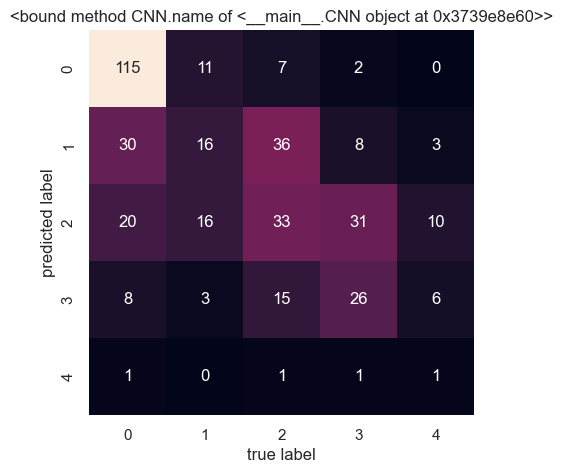

*******   Classification Report: *********
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       174
           1       0.17      0.35      0.23        46
           2       0.30      0.36      0.33        92
           3       0.45      0.38      0.41        68
           4       0.25      0.05      0.08        20

    accuracy                           0.48       400
   macro avg       0.40      0.36      0.36       400
weighted avg       0.55      0.48      0.50       400

CPU times: user 2min 9s, sys: 1min 22s, total: 3min 31s
Wall time: 5min 29s


In [203]:
#@title Run the CNN model
cnn_model = CNN()
setgpu()
%time history = train_eval(cnn_model,(X_train,Y_train),(X_val,Y_val),(X_test,Y_test))


In [204]:
#@title Define function to plot loss curve Assuming
def plot_loss_curve(history,listOfMetrics):
    for metric in listOfMetrics:
        if metric not in history.history:
            print(f"Metric '{metric}' not found in history.")
            continue
        else:
            plt.plot(history.history[metric], label=f'{metric}')

    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

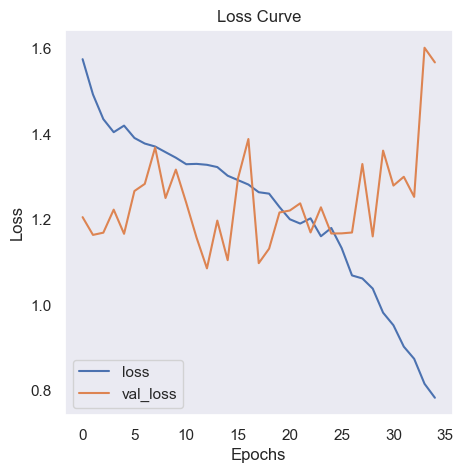

In [205]:
#@title Plot the loss curve
plot_loss_curve(history,['loss','val_loss'])


In [ ]:
cnn_model.model.save('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/accuracy52_resnet_weights.keras')

Start of GAN architecture

In [146]:
#@title Utility methods part 2
X_train=[]
Y_train=[]
def prepare_data_set(data):
  for sample in data:
    img = sample[0]
    label = sample[1][0]

    X_train.append(np.array(img,dtype='float32')/255.0)
    Y_train.append(label)


prepare_data_set(class4_dataset)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(X_train.shape,Y_train.shape)

(66, 64, 64, 3) (66,)


In [ ]:
#@title Augment class 4 samples for GAN Training
def augment_class4_samples():
    class4_samples = []
    for img in X_train:
        # Rotate the image by 90 degrees
        rotated_img = np.rot90(img)
        class4_samples.append(rotated_img)

        # Flip the image horizontally
        flipped_img = np.fliplr(img)
        class4_samples.append(flipped_img)

        # Flip the image vertically
        flipped_img_vertical = np.flipud(img)
        class4_samples.append(flipped_img_vertical)

    return class4_samples


In [ ]:
augmented_data = augment_class4_samples()
X_train = np.concatenate((X_train, np.array(augmented_data)), axis=0)
X_train.shape

(264, 64, 64, 3)

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((X_train))
ds = ds.batch(128)
ds = ds.shuffle(buffer_size=1080)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
ds.as_numpy_iterator().next()[0].shape

(64, 64, 3)

In [ ]:
# #@title Architecting Generator
# from tensorflow.keras.layers import (
#     Conv2DTranspose, BatchNormalization, LeakyReLU, Input, Activation,Dense,Reshape,Conv2D
# )
# from tensorflow.keras.models import Model

# def retinaGenerator(latent_dim=128):
#     inputs = Input((latent_dim,))

#     # project & reshape to a small “seed” feature map
#     x = Dense(4*4*512, use_bias=False)(inputs)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(0.2)(x)
#     x = Reshape((4,4,512))(x)

#     # upsample to 8×8
#     x = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(0.2)(x)

#     # upsample to 16×16
#     x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(0.2)(x)

#     # upsample to 32×32
#     x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(0.2)(x)

#     # upsample to 64×64
#     x = Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(0.2)(x)


#     # final RGB output
#     x = Conv2D(3, kernel_size=3, padding='same')(x)
#     outputs = Activation('tanh')(x)

#     return Model(inputs, outputs, name='retina_generator')


In [ ]:
##Resnet model in image generation

from tensorflow.keras.layers import (
    Input, Dense, Reshape,
    Conv2DTranspose, Conv2D,
    BatchNormalization, Activation,
    Add
)
from tensorflow.keras.models import Model

def up_res_block(x, filters, kernel_size=3):
    """
    A residual upsampling block:
      - Main:   Conv2DTranspose(stride=2) → BN → ReLU → Conv2D → BN
      - Skip:   Conv2DTranspose(1×1, stride=2)
      - Merge:  Add → ReLU
    """
    shortcut = Conv2DTranspose(filters, 1, strides=2, padding='same', use_bias=False)(x)

    # Main path
    y = Conv2DTranspose(filters, kernel_size, strides=2, padding='same', use_bias=False)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)

    out = Add()([shortcut, y])
    return Activation('relu')(out)

def retinaGenerator(latent_dim=128):
    inp = Input((latent_dim,))

    # 1) Project & reshape to 4×4×512
    x = Dense(4*4*512, use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape((4, 4, 512))(x)

    # 2) Four up‐sampling residual blocks: 8×8 → 16×16 → 32×32 → 64×64
    for f in [256, 128, 64, 32]:
        x = up_res_block(x, f)

    # 3) Final RGB projection
    x = Conv2D(3, kernel_size=3, padding='same')(x)
    out = Activation('tanh')(x)

    return Model(inp, out, name='retina_generator_resnet_decoder')


In [ ]:
generator = retinaGenerator()
generator.summary()

Model: "retina_generator_resnet_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8192)      │  1,048,576 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8192)      │     32,768 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 8192)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 4, 4, 512) │          0 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_25 │ (None, 8, 8, 256) │  1,179,648 │ reshape_3[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8, 256) │    589,824 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 8, 8, 256) │    131,072 │ reshape_3[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 8, 8, 256) │          0 │ conv2d_transpose… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 8, 8, 256) │          0 │ add_12[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_27 │ (None, 16, 16,    │    294,912 │ activation_32[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │    147,456 │ activation_33[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_26 │ (None, 16, 16,    │     32,768 │ activation_32[0]

 Total params: 3,610,211 (13.77 MB)

 Trainable params: 3,591,907 (13.70 MB)

 Non-trainable params: 18,304 (71.50 KB)

In [ ]:
#@title Model Architecture - Discriminator
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Activation

def retinaDiscriminator():
  model = tf.keras.Sequential()
  ( model.add(Conv2D(96,kernel_size=3,padding='same',input_shape=(64,64,3))))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))


  (model.add(Conv2D(54,kernel_size=4)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  (model.add(Conv2D(48,4)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))


  (model.add(Conv2D(18,4)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(500,activation='relu'))

  model.add(Dense(1))

  return model

In [ ]:
descriminator = retinaDiscriminator()
descriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 64, 64, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 61, 54)     │        82,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 61, 61, 54)     │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 61, 61, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 61, 61, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 58, 58, 48)     │        41,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 58, 58, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 58, 58, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 55, 55, 18)     │        13,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 55, 55, 18)     │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 55, 55, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 55, 55, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 54450)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 500)            │    27,225,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,367,913 (104.40 MB)

 Trainable params: 27,367,481 (104.40 MB)

 Non-trainable params: 432 (1.69 KB)

2025-04-26 15:21:06.209865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06709677..0.08021773].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[0.00110811]
 [0.00075943]
 [0.00109323]]


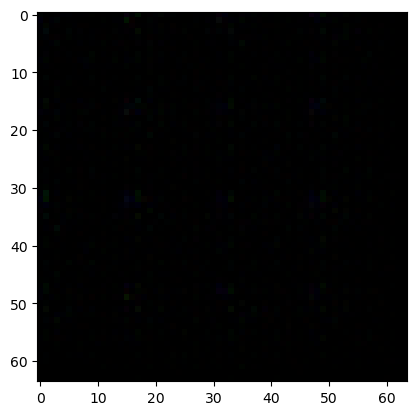

In [ ]:
#@title Print Sample image using generator
img = generator.predict(np.random.randn(3,128))
plt.imshow(np.array(img[2],dtype='float32'))

result = descriminator.predict(img)
print(result)


In [ ]:
#@title Defining Training loop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

gen_learningRate = 3e-4
disc_learningRate = 3e-5

gen_learningRate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(gen_learningRate,decay_steps=4800,end_learning_rate=9e-5,cycle=True)
disc_learningRate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(disc_learningRate,decay_steps=2000,end_learning_rate=8e-7,cycle=True)

# gen_learningRate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(gen_learningRate, decay_steps=1000, decay_rate=0.95)
# disc_learningRate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(disc_learningRate, decay_steps=1000, decay_rate=0.95)


genOptimizer = Adam(learning_rate=gen_learningRate,beta_1=0.0,beta_2=0.999)
discOptimizer = Adam(learning_rate=disc_learningRate,beta_1=0.0,beta_2=0.999)

lossFunction = BinaryCrossentropy(from_logits=False)




In [ ]:
#@title Define class for RetinaGAN
import tensorflow as tf
from tensorflow.keras import Model

class RetinaGAN(Model):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.generator = retinaGenerator()
        self.discriminator = retinaDiscriminator()
        self.latent_dim = latent_dim

    def compile(self, gen_optimizer, disc_optimizer, loss_fn, useWeights):
        super().compile()  # no optimizers or losses here either
        #load generator and discriminator weights if already exists.
        try:
          if useWeights:
            print('loading weights')
            self.generator.load_weights('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/generator.weights.h5')
            self.discriminator.load_weights('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/discriminator.weights.h5')
            print('weights loaded')
        except Exception as e:
          print('Error loading weights',e)

        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn

    def d_hinge_loss(self, real_logits, fake_logits):
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
        return real_loss + fake_loss

    def g_hinge_loss(self,fake_logits):
      return -tf.reduce_mean(fake_logits)

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # 1) scale inputs if using tanh
        real_images = (real_images - 0.5) * 2.0

        # 2) sample noise
        noise = tf.random.normal([batch_size, self.latent_dim])

        # 3) train discriminator with hinge loss

        for _ in range(4):

          with tf.GradientTape() as disc_tape:
              fake_images = self.generator(noise, training=True)
              real_logits = self.discriminator(real_images, training=True)
              fake_logits = self.discriminator(fake_images, training=True)

              d_loss = self.d_hinge_loss(real_logits, fake_logits)

          d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
          d_grads, _ = tf.clip_by_global_norm(d_grads, 1.0)
          self.disc_optimizer.apply_gradients(
              zip(d_grads, self.discriminator.trainable_weights)
          )

        # 4) train generator with hinge loss
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(noise, training=True)
            fake_logits = self.discriminator(fake_images, training=True)

            g_loss = self.g_hinge_loss(fake_logits)

        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights)
        )

        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
#@title Create directory to store generated images
currentDate = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
image_dir_path = f'/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/generated_images_gL_{gen_learningRate}_dL{disc_learningRate}_{currentDate}'
if not os.path.exists(image_dir_path):
    os.makedirs(image_dir_path)


In [ ]:
#@title Callback
from tensorflow.keras.callbacks import Callback
class RetinaGANMonitor(Callback):
  def __init__(self,num_img=20,latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img,self.latent_dim))
    generated_images = self.model.generator.predict(random_latent_vectors)
    generated_images = (generated_images*255).astype(np.uint8)
    # create directory to store images if not exists


    for i in range(self.num_img):
      img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
      img.save(f"{image_dir_path}/img-epoch-{epoch:03d}_{i}.png")

In [ ]:
#@title Run
retinaGAN = RetinaGAN()
retinaGAN.compile(genOptimizer,discOptimizer,lossFunction,useWeights=False)

history = retinaGAN.fit(ds,epochs=700,callbacks=[RetinaGANMonitor()])

Epoch 1/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - d_loss: 0.0000e+00 - g_loss: 5.6673
Epoch 2/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - d_loss: 2.4668e-04 - g_loss: 6.3692
Epoch 3/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - d_loss: 0.0000e+00 - g_loss: 6.4297
Epoch 4/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - d_loss: 0.0000e+00 - g_loss: 6.0856
Epoch 5/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - d_loss: 0.0000e+00 - g_loss: 10.1062
Epoch 6/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - d_loss: 0.0000e+00 - g_loss: 9.4908
Epoch 7/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - d_loss: 0.0000e+00 - g_loss: 5.1759
Epoch 8/700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - d_loss: 0.0000e+00 - g_loss: 7.122

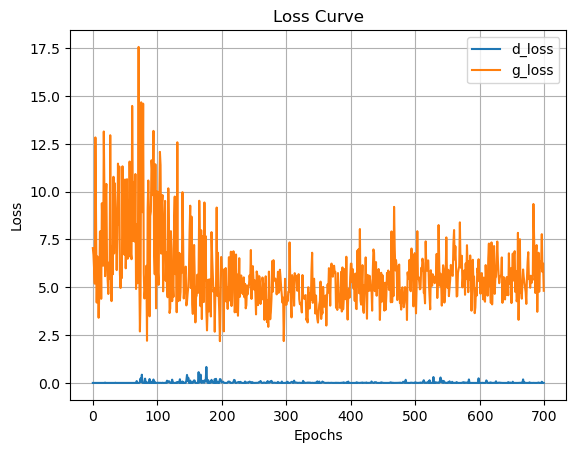

In [ ]:
metrics_list = ["d_loss", "g_loss"]

plot_loss_curve(history, metrics_list)



In [ ]:
#@title Save weights
retinaGAN.generator.save_weights(f'/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/{currentDate}-generator.weights.h5')
retinaGAN.discriminator.save_weights(f'/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/{currentDate}-discriminator.weights.h5')

In [ ]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# ——— 1) Paths ———
fake_dir = image_dir_path

# ——— 2) Load & preprocess all real images from class4_dataset ———
real_imgs = []
for img, _label in class4_dataset:
    arr = np.array(img)                   # PIL.Image → H×W×C or H×W
    if arr.ndim == 3:
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    arr = cv2.resize(arr, (64, 64))       # ensure 64×64
    arr = arr.astype(np.float32) / 255.0  # normalize to [0,1]
    real_imgs.append(arr)
real_imgs = np.stack(real_imgs, axis=0)   # shape = (N_real, 64, 64)

print('real image shape:', real_imgs[0].shape)

# ——— 3) Compute SSIM for each fake image ———
scores = []
for fn in os.listdir(fake_dir):
    fpath = os.path.join(fake_dir, fn)
    fake = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    fake = cv2.resize(fake, (64, 64))
    fake = fake.astype(np.float32) / 255.0

    # compare against all reals
    sims = [
        ssim(fake, real, data_range=1.0)
        for real in real_imgs
    ]
    scores.append((fn, max(sims)))

# ——— 4) Sort & pick top-50 ———
scores.sort(key=lambda x: x[1], reverse=True)
top50 = scores[:50]

print("Top 50 generated images by SSIM:")
for fn, score in top50:
    print(f"{fn}: SSIM={score:.4f}")



real image shape: (64, 64)
Top 50 generated images by SSIM:
img-epoch-673_15.png: SSIM=0.7135
img-epoch-223_7.png: SSIM=0.7021
img-epoch-366_14.png: SSIM=0.6957
img-epoch-681_19.png: SSIM=0.6936
img-epoch-517_13.png: SSIM=0.6912
img-epoch-680_7.png: SSIM=0.6898
img-epoch-678_3.png: SSIM=0.6881
img-epoch-383_14.png: SSIM=0.6877
img-epoch-518_18.png: SSIM=0.6849
img-epoch-103_8.png: SSIM=0.6843
img-epoch-386_4.png: SSIM=0.6833
img-epoch-349_2.png: SSIM=0.6830
img-epoch-675_13.png: SSIM=0.6825
img-epoch-381_15.png: SSIM=0.6824
img-epoch-382_12.png: SSIM=0.6815
img-epoch-484_13.png: SSIM=0.6795
img-epoch-479_0.png: SSIM=0.6729
img-epoch-122_9.png: SSIM=0.6724
img-epoch-121_5.png: SSIM=0.6720
img-epoch-495_1.png: SSIM=0.6716
img-epoch-683_0.png: SSIM=0.6710
img-epoch-517_4.png: SSIM=0.6669
img-epoch-376_15.png: SSIM=0.6621
img-epoch-390_10.png: SSIM=0.6604
img-epoch-669_11.png: SSIM=0.6602
img-epoch-517_2.png: SSIM=0.6601
img-epoch-386_2.png: SSIM=0.6593
img-epoch-478_11.png: SSIM=0.6574
im

In [158]:
import shutil
base_dir = '/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/'
print(base_dir)
save_dir = f"{base_dir}best_generatedimages/{currentDate}"
print(save_dir)
os.makedirs(save_dir, exist_ok=True)
for fn,_ in top50:
    shutil.copy(os.path.join(fake_dir, fn), save_dir)

/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/


NameError: name 'currentDate' is not defined

# Retrain the CNN model using the synthetic images

In [347]:
#@title Prepare train dataset augmenting the synthetic dataset

from PIL import Image
fake_imgs_folder = f'/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/best_generatedimages/20250426-152111'
img_list =[]
print('dir',fake_imgs_folder)
for img in os.listdir(fake_imgs_folder):
  img_path = os.path.join(fake_imgs_folder,img)
  img = Image.open(img_path)
  img = img.convert('RGB')
  img = img.resize((64, 64))

  img_list.append((img,np.array([4])))


dir /Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/best_generatedimages/20250426-152111


In [348]:
#@title Augment to X_train list

# augment_x_train, augment_y_train = prepare_x_y_columns(img_list)

# X_train = np.concatenate((X_train,augment_x_train),axis=0)
# print(X_train.shape)
# print(X_train[0].shape)

normalized_image_list = [(normalize_image(np.array(x[0])),to_categorical(x[1])) for x in img_list]



In [349]:
imgs, labels = zip(*normalized_image_list)      # imgs is tuple of arrays, labels is tuple of one-hots
imgs = np.array(imgs)
labels = np.array(np.squeeze(labels))


In [350]:
X_train.shape,Y_train.shape

((2264, 64, 64, 3), (2264, 5))

In [280]:
# Y_train = np.concatenate((Y_train,augment_y_train),axis=0)
# Y_train.shape


In [351]:
X_train_aug = np.concatenate((X_train,imgs),axis=0)
Y_train_aug = np.concatenate((Y_train,labels),axis=0)


In [352]:
aug_ds = tf.data.Dataset.from_tensor_slices((X_train_aug,Y_train_aug))
aug_ds = ds.batch(128)
aug_ds = ds.shuffle(buffer_size=2000)
aug_ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

aug_data = list(aug_ds)

2025-04-27 21:58:17.914642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [353]:

X_train = []
Y_train = []

for sample in aug_data:

  break
  X_train.append(img)
  Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [355]:
len(X_train_aug),len(Y_train_aug)

(2314, 2314)

Running fit method of CNN
Epoch 1/35


2025-04-27 21:58:48.806104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - auc: 0.5273 - f1_score: 0.1627 - loss: 1.6089 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6747 - val_f1_score: 0.0757 - val_loss: 1.5893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - auc: 0.5357 - f1_score: 0.1226 - loss: 1.6042 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5958 - val_f1_score: 0.0364 - val_loss: 1.5929 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/35
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - auc: 0.5485 - f1_score: 0.1312 - loss: 1.5994 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5583 - val_f1_score: 0.0757 - val_loss: 1.5648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/35
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - auc: 0.5517 - f1_score: 0.1393 - loss: 1.5959 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6832 - val_f1_score: 0.1241 - val_loss: 1.5610 - val_precision: 0.0000e+00 

2025-04-27 22:04:46.875901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
*******   Confusion Matrix *********


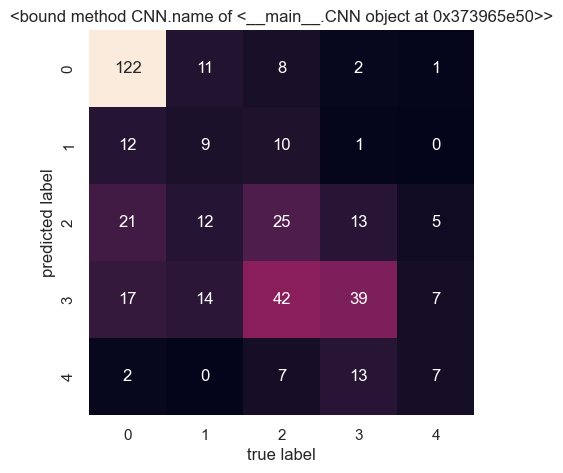

*******   Classification Report: *********
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       174
           1       0.28      0.20      0.23        46
           2       0.33      0.27      0.30        92
           3       0.33      0.57      0.42        68
           4       0.24      0.35      0.29        20

    accuracy                           0.51       400
   macro avg       0.41      0.42      0.40       400
weighted avg       0.54      0.51      0.51       400

CPU times: user 2min 13s, sys: 2min 10s, total: 4min 24s
Wall time: 6min


In [357]:
augment_cnn_model = CNN()
%time history = train_eval(augment_cnn_model,(X_train_aug,Y_train_aug),(X_val,Y_val),(X_test,Y_test))

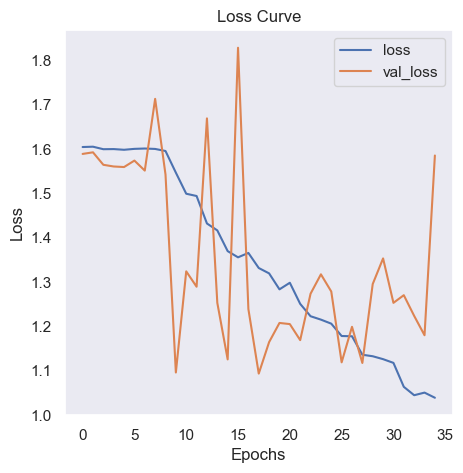

In [358]:
#plot loss curve
plot_loss_curve(history,['loss','val_loss'])